%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from rlglue import RLGlue
import main_agent
import ten_arm_env
import test_env
from tqdm import tqdm
import time

In [18]:
pwd

'C:\\Users\\templ'

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
#Plotting the history of interactions with the environment
def plot_history(history):
  rewards = history["rewards"]
  cuml_rewards = history["cuml_rewards"]
  chosen_arms = history["arms"]

  fig = plt.figure(figsize=[30,8])

  ax2 = fig.add_subplot(121)
  ax2.plot(cum_rewards, label="avg rewards")
  ax2.set_title("Cummulative Rewards")

  ax3 = fig.add_subplot(122)
  ax3.bar([i for i in range(len(chosen_arms))], chosen_arms, label="chosen arms")
  ax3.set_title("Chosen Actions")

In [41]:
class Env(object):

      def __init__(self, reward_prob, reward):#reward is the list containing the actual reward, reward_prob contains the probabilities of rewards by each arm
        if len(reward_prob) != len(reward):
              raise Exception("Size of reward probabilities and actual reward list is unequal!")

        self.reward_prob = reward_prob
        self.reward = reward 
        self.k_arms = len(reward)

      def choose_arm(self, arm): #the arm we are going to pull, e.x. a handle on the classic slot machine analogy
        if arm < 0 or arm > self.k_arms:
          raise Exception("Invalid arm count")

        return self.reward[arm] if np.random.random() < self.reward_prob[arm] else 0.0
 #Picking a random number from np.random, we see if it is less than that allocated probability 
                                                                               #if yes, we go ahead and pass the reward to self.reward or pass zero in the converse case.

In [43]:
environment=Env(reward_prob=[0.01,1.00,0.75,0.99,1.00],reward=[95.0,0.0,25.5,10.05,2.50]) #the first arm has a 0.01% chance of giving a reward and so on,so forth.
print(f"Reward Probabilities\t\t: {environment.reward_prob}")
print(f"Actual Rewards\t\t: {environment.reward}")

Reward Probabilities		: [0.01, 1.0, 0.75, 0.99, 1.0]
Actual Rewards		: [95.0, 0.0, 25.5, 10.05, 2.5]


In [49]:
[environment.choose_arm(0)for _ in range(10)]#pulling arms to see what rewards we get

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [71]:
#creating an agent that pulls arms randomly, acts as a base case
class RandomAgent(object):

  def __init__(self, env, max_iterations=2000):
    self.env = env
    self.iterations = max_iterations

  def act(self):
    arm_counts = np.zeros(self.env.k_arms)
    rewards = []
    cum_rewards = []

    for i in range(1, self.iterations + 1):
      arm = np.random.choice(self.env.k_arms)
      reward = self.env.choose_arm(arm)

      arm_counts[arm] += 1
      rewards.append(reward)
      cum_rewards.append(sum(rewards)/ len(rewards))

    return {"arms": arm_counts, "rewards": rewards, "cum_rewards": cum_rewards}


In [73]:
random_agent=RandomAgent(env=environment,max_iterations=2000)
ra_hist=random_agent.act()
print(f"TOTAL REWARD : {sum(ra_hist['rewards'])}")

TOTAL REWARD : 13526.049999999896


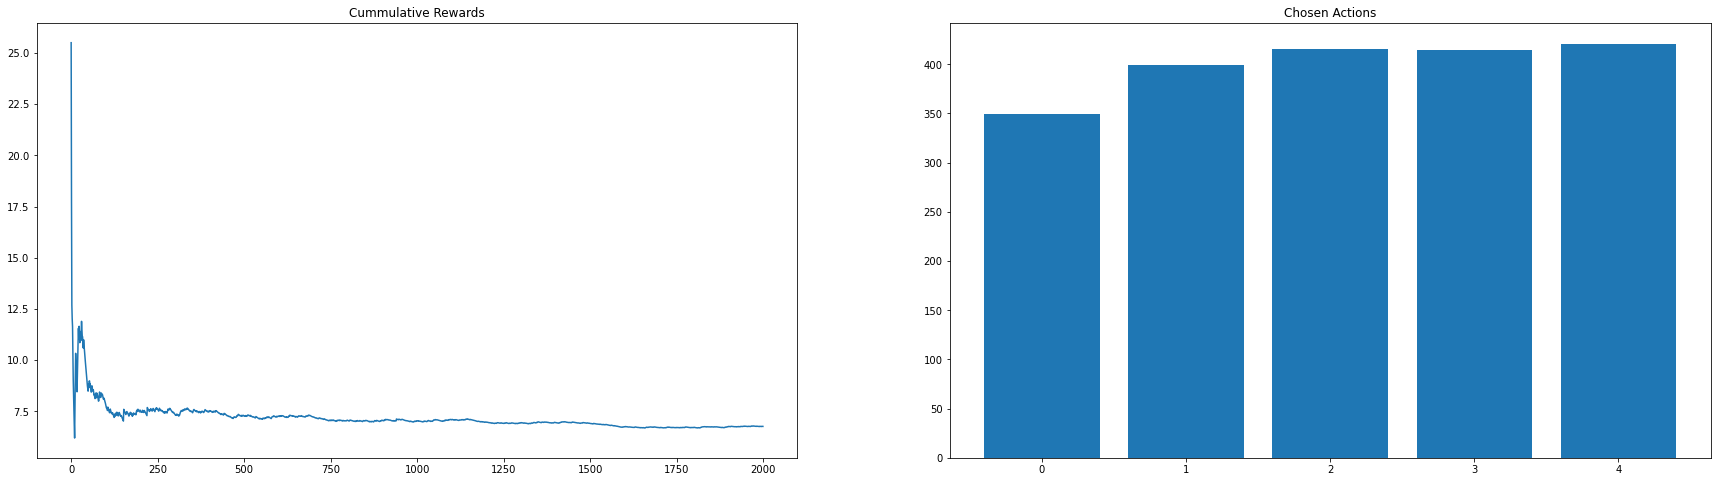

In [75]:
plot_history(ra_hist)#plot the actions of the agent, by using the dict returned by .act()

#The max amount you can amass with the random agent is 13526.049999999896. The random agent picks arms randomly and does not behave inteliigently, as shown by its cumulative rewards.The agent does not exploit, only explores, resulting in sub-optimal rewards.

In [80]:
#an agent based on the epsilon greedy action selection method
class EpsilonGreedyAgent(object): 
    def __init__(self,env,max_iterations=2000,epsilon=0.01):
        self.env=env
        self.iterations=max_iterations
        self.epsilon=epsilon
        
    def act(self):
        q_values=np.zeros(self.env.k_arms)
        arm_rewards=np.zeros(self.env.k_arms)
        arm_counts=np.zeros(self.env.k_arms)
        rewards=[]
        cum_rewards=[]
        
        for i in range(1,self.iterations+1):
            arm=np.random.choice(self.env.k_arms) if np.random.random() < self.epsilon else np.argmax(q_values)
            #randomly choose another arm if a random number falls below our epsilong, EXPLORATION
            #Choose the INDEX of the max entity available from q_max, which is our action-value estimates, EXPLOITATION
            reward=self.env.choose_arm(arm)
            
            arm_rewards[arm]+=reward
            arm_counts[arm]+=1
            q_values[arm]=arm_rewards[arm]/arm_counts[arm] #Estimating values using sample avergae method,
            #incremental implementation can also be done
            rewards.append(reward)
            cum_rewards.append(sum(rewards)/ len(rewards))
        
        return {"arms": arm_counts, "rewards": rewards, "cum_rewards": cum_rewards}


In [81]:
egreedy_agent = EpsilonGreedyAgent(environment, max_iterations=2000, epsilon=0.1)#exploring 1 out of 10 times
eg_history = egreedy_agent.act()
print(f"TOTAL REWARD : {sum(eg_history['rewards'])}")

TOTAL REWARD : 34741.69999999998


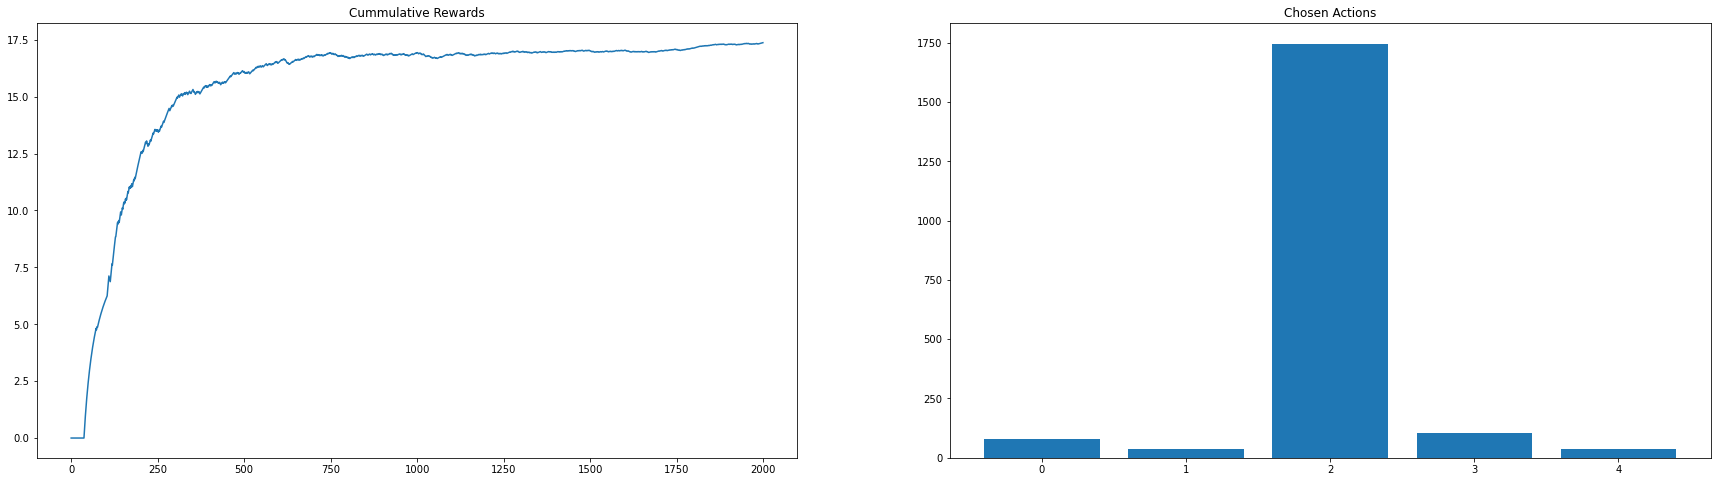

In [82]:
plot_history(eg_history)#plot the actions of the agent, by using the dict returned by .act()

The epsilon-greedy method shows a total reward of 34741.6999. It identifies arm 2 as the best.

In [83]:
#a purely greedy algorithm
class pureGreedyAgent(object): 
    def __init__(self,env,max_iterations=2000):
        self.env=env
        self.iterations=max_iterations
        
        
    def act(self):
        q_values=np.zeros(self.env.k_arms)
        arm_rewards=np.zeros(self.env.k_arms)
        arm_counts=np.zeros(self.env.k_arms)
        rewards=[]
        cum_rewards=[]
        
        for i in range(1,self.iterations+1):
            arm= np.argmax(q_values)
            
            
            reward=self.env.choose_arm(arm)
            
            arm_rewards[arm]+=reward
            arm_counts[arm]+=1
            q_values[arm]=arm_rewards[arm]/arm_counts[arm] #Estimating values using sample avergae method,
            #incremental implementation can also be done
            rewards.append(reward)
            cum_rewards.append(sum(rewards)/ len(rewards))
        
        return {"arms": arm_counts, "rewards": rewards, "cum_rewards": cum_rewards}


In [84]:
pgreedy_agent = pureGreedyAgent(environment, max_iterations=2000)
pg_history = pgreedy_agent.act()
print(f"TOTAL REWARD : {sum(pg_history['rewards'])}")

TOTAL REWARD : 1710.0


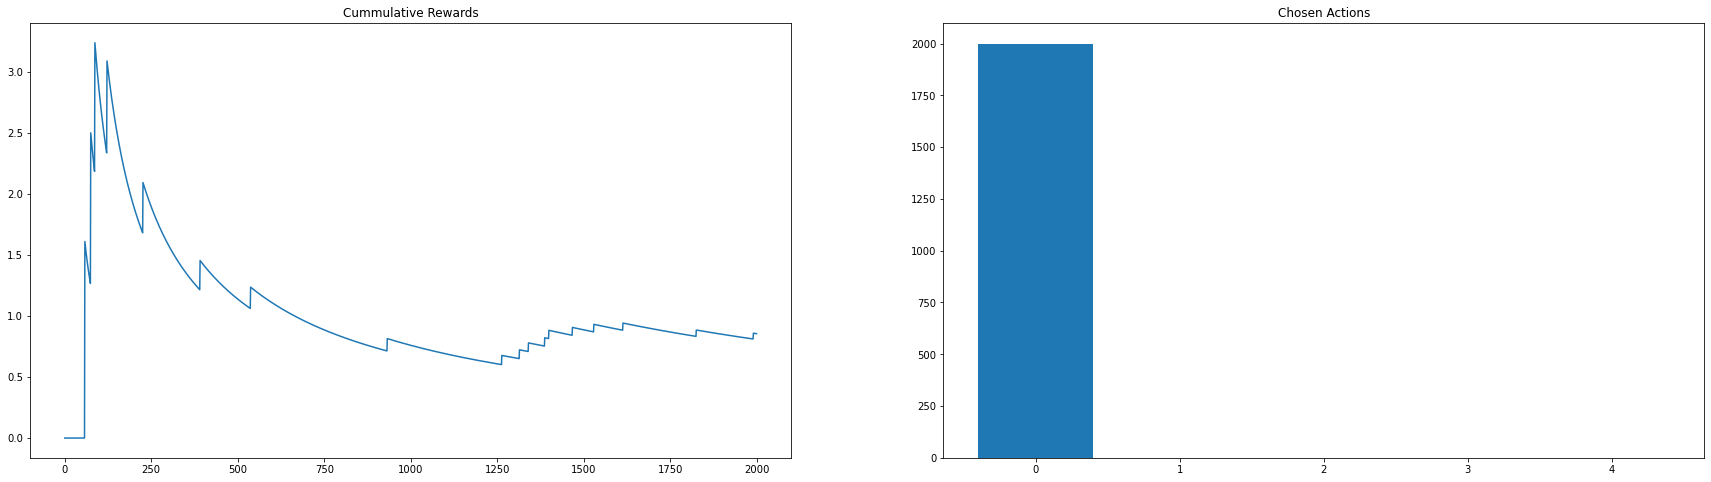

In [85]:
plot_history(pg_history)

A purely greedy algorithm, i.e. an algorithm that only exploits, shows high rewards at the starting timesteps (even better than epsilon greedy) as it latches on to arm 0, which has the most value availabale, albeit with poor probability. Due to the agent not exploring at all, it performs sub-optimal actions as time-steps increase, causing a sharp decrease in reward.